# Visualization of Loan Thresholds For FICO Data

In this notebook, we visualize the positions of the loan thresholds resulting from bank Profit Maximization under various Fairness Criteria. We compare this value with the threshold on the disadvantaged population experiencing Improvement or Decline.

In [1]:
! python3 -V

Python 3.8.5


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# import all of our files
import sys
sys.path.append('../')

import fico
import distribution_to_loans_outcomes as dlo

DATA_DIR = '../data/'

Populating the interactive namespace from numpy and matplotlib


In [4]:
# set plotting parameters
sns.set_context("talk")
sns.set_style("white")

# this needs to be here so we can edit figures later
plt.rcParams['pdf.fonttype'] = 42

# 0. Load and parse data

In [23]:
all_cdfs, performance, totals = fico.get_FICO_data(data_dir=DATA_DIR);

In [8]:
cdfs = all_cdfs[["White","Black"]]

# B is White
# A is Black

cdf_B = cdfs['White'].values
cdf_A = cdfs['Black'].values

repay_B = performance['White']
repay_A = performance['Black']

scores = cdfs.index
scores_list = scores.tolist()
scores_repay = cdfs.index

In [21]:
print(type(cdf_B))
print(cdf_B)

<class 'numpy.ndarray'>
[1.000e-04 2.600e-03 1.160e-02 1.430e-02 1.800e-02 2.090e-02 2.550e-02
 2.960e-02 3.390e-02 3.540e-02 4.190e-02 4.720e-02 5.280e-02 5.560e-02
 6.110e-02 6.340e-02 6.810e-02 7.020e-02 7.340e-02 7.600e-02 7.950e-02
 8.200e-02 8.620e-02 8.940e-02 9.560e-02 9.920e-02 1.040e-01 1.076e-01
 1.141e-01 1.175e-01 1.229e-01 1.261e-01 1.309e-01 1.343e-01 1.384e-01
 1.413e-01 1.456e-01 1.484e-01 1.524e-01 1.550e-01 1.654e-01 1.688e-01
 1.737e-01 1.764e-01 1.807e-01 1.838e-01 1.877e-01 1.913e-01 1.973e-01
 2.009e-01 2.054e-01 2.084e-01 2.127e-01 2.167e-01 2.227e-01 2.262e-01
 2.319e-01 2.355e-01 2.428e-01 2.471e-01 2.524e-01 2.559e-01 2.622e-01
 2.658e-01 2.707e-01 2.748e-01 2.800e-01 2.840e-01 2.894e-01 2.943e-01
 3.016e-01 3.042e-01 3.117e-01 3.150e-01 3.227e-01 3.261e-01 3.336e-01
 3.366e-01 3.432e-01 3.456e-01 3.509e-01 3.548e-01 3.606e-01 3.633e-01
 3.697e-01 3.735e-01 3.797e-01 3.836e-01 3.898e-01 3.954e-01 4.003e-01
 4.056e-01 4.113e-01 4.150e-01 4.226e-01 4.259e-01 4.

In [18]:
print(scores_repay)

Float64Index([             300.0,  311.9047619047619,  323.8095238095238,
               335.7142857142857,  347.6190476190476, 354.76190476190476,
               360.7142857142857,  366.6666666666667,  372.6190476190476,
              378.57142857142856,
              ...
               810.5263157894738,  814.9122807017544,  819.2982456140351,
               823.6842105263158,  828.0701754385965,  832.4561403508773,
               836.8421052631579,  841.2280701754386,  845.6140350877193,
                           850.0],
             dtype='float64', length=198)


In [22]:
print(type(repay_B))
print(repay_B)

<class 'pandas.core.series.Series'>
300.000000    0.0146
311.904762    0.0205
323.809524    0.0264
335.714286    0.0323
347.619048    0.0382
               ...  
832.456140    0.9899
836.842105    0.9902
841.228070    0.9905
845.614035    0.9907
850.000000    0.9910
Name: White, Length: 198, dtype: float64


In [9]:
# to populate group distributions
def get_pmf(cdf):
    pis = np.zeros(cdf.size)
    pis[0] = cdf[0]
    for score in range(cdf.size-1):
        pis[score+1] = cdf[score+1] - cdf[score]
    return pis

# to get loan repay probabilities for a given score
loan_repaid_probs = [lambda i: repay_A[scores[scores.get_loc(i,method='nearest')]], 
                     lambda i: repay_B[scores[scores.get_loc(i,method='nearest')]]]


In [10]:
# basic parameters
N_scores = cdf_B.size
N_groups = 2

# get probability mass functions of each group
pi_A = get_pmf(cdf_A)
pi_B = get_pmf(cdf_B)
pis = np.vstack([pi_A, pi_B])

# demographic statistics 
group_ratio = np.array((totals["Black"], totals["White"]))
group_size_ratio = group_ratio/group_ratio.sum()
print(group_size_ratio)


[0.12066905 0.87933095]


## Set Profit and Impact Parameters

In [11]:
# profit and impact
utility_repaid_1 = 1
utility_default_1 = -4
utility_repaid_2 = 1
utility_default_2 = -10

score_change_repay = 75
score_change_default = -150

# considering several utility ratios to understand sensitivity of qualitative results
util_repay = [[utility_default_1,utility_repaid_1], [utility_default_2,utility_repaid_2]]

impact=[score_change_default,score_change_repay]

In [24]:
### FOR THE INVERSE TRANSFORMATION SAMPLING
import numpy as np
import scipy.interpolate as interpolate

# in the convert_percentiles they have 12 pdf tuples, so do 12 bins?
def inverse_transform_sampling(data, n_bins=12, n_samples=1000):
    hist, bin_edges = np.histogram(data, bins=n_bins, density=True)
    cum_values = np.zeros(bin_edges.shape)
    cum_values[1:] = np.cumsum(hist*np.diff(bin_edges))
    inv_cdf = interpolate.interp1d(cum_values, bin_edges)
    r = np.random.rand(n_samples)
    return inv_cdf(r)


In [ ]:
# TODO 1: check what data is needed for a histogram
# TODO 2: prepare data --> by race, so have one array or pandas df for each
# TODO 3: run the inverse_transform_sampling function twice
# TODO 4: once I have samples for white and black groups --> 

# 1. Visualize Repay Probabilities from the data

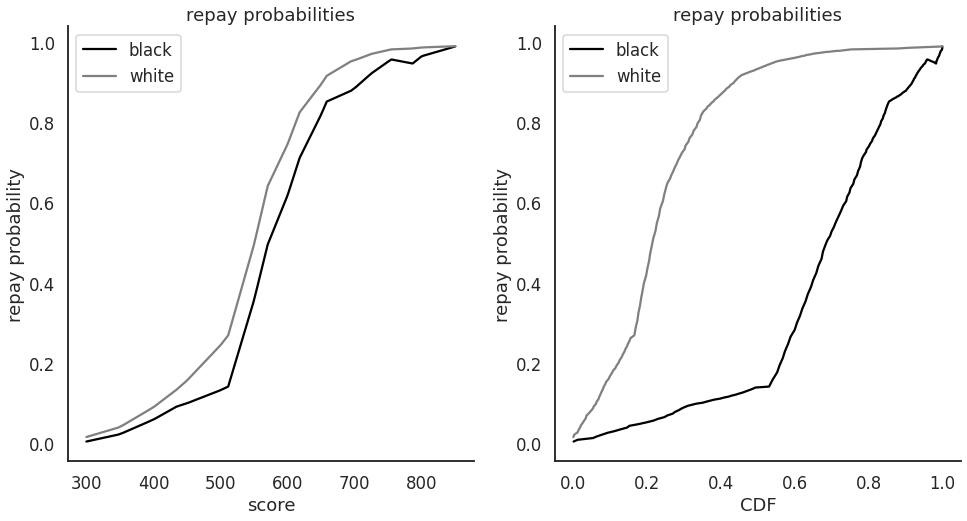

In [12]:
# plot the repay probabilities
fig, ax = plt.subplots(1,2,figsize=(16,8)); 

ax[0].plot(scores_list,repay_A,color='black',label='black')
ax[0].plot(scores_list,repay_B,label='white',color="grey")
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].set_title("repay probabilities")
ax[0].set_xlabel("score")
ax[0].set_ylabel("repay probability")
ax[0].legend()

ax[1].plot(cdf_A,repay_A,color='black',label='black')
ax[1].plot(cdf_B,repay_B,label='white',color="grey")
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].set_title("repay probabilities")
ax[1].set_xlabel("CDF")
ax[1].set_ylabel("repay probability")
ax[1].legend()


# 2. Compute thresholds and visualize on group CDFs

In [13]:
threshes = []
for utils in util_repay:
    threshes.append(dlo.get_thresholds(loan_repaid_probs, pis, group_size_ratio,
                                                utils, impact, scores_list))

<ipython-input-14-b552db39f226>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax[i].axvline(threshes_downward[0],LineStyle='-', color='yellow',label="thresh-active-harm A")
<ipython-input-14-b552db39f226>:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax[i].axvline(threshes_MP[0],LineStyle='-', color='orange',label="MP A")
<ipython-input-14-b552db39f226>:13: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax[i].axvline(threshes_DP[0],LineStyle='-', color='cyan',label="DP A")
<ipython-input-14-b552db39f226>:14: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax[i].axvline(threshes_EO[0],LineStyle='-', color='purple',label="EO A")


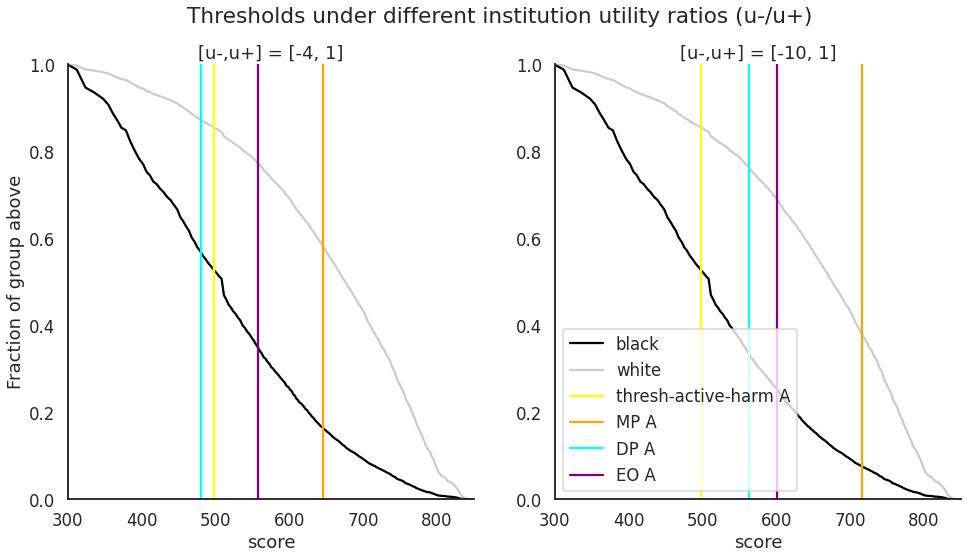

In [14]:
# plot the threshes
fig, ax = plt.subplots(1,len(threshes),figsize=(16,8)); 
plt.title("")
for i,thresh in enumerate(threshes):
    # unpack
    threshes_DP, threshes_EO, threshes_MP, threshes_downward = thresh
    ax[i].plot(scores, 1 - cdf_A, label='black',color="black"); 
    ax[i].plot(scores,1 - cdf_B, label='white',color="grey",alpha=0.4); 
    
    ax[i].set_xlabel("score")
    ax[i].axvline(threshes_downward[0],LineStyle='-', color='yellow',label="thresh-active-harm A")
    ax[i].axvline(threshes_MP[0],LineStyle='-', color='orange',label="MP A")
    ax[i].axvline(threshes_DP[0],LineStyle='-', color='cyan',label="DP A")
    ax[i].axvline(threshes_EO[0],LineStyle='-', color='purple',label="EO A")
    ax[i].set_title("[u-,u+] = {0}".format(util_repay[i]))
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].set_ylim([0,1])
    ax[i].set_xlim([300,850])

    plt.suptitle("Thresholds under different institution utility ratios (u-/u+)")
    
ax[0].set_ylabel("Fraction of group above")
plt.legend(loc='lower left')


# Plot utility and outcome curves

In [15]:
# get outcome curves

outcome_curveA = dlo.get_outcome_curve(loan_repaid_probs[0],pis[0],scores,impact)
outcome_curveB = dlo.get_outcome_curve(loan_repaid_probs[1],pis[1],scores,impact)

rate_index_A = list(reversed(1- cdf_A))
rate_index_B = list(reversed(1- cdf_B))

In [16]:
# get utility curves
utility_curves = dlo.get_utility_curve(loan_repaid_probs,pis, scores,utils=util_repay[0])
util_MP = np.amax(utility_curves, axis=1)

utility_curves_MP = np.vstack([utility_curves[0] + util_MP[1], utility_curves[1]+ util_MP[0]])
utility_curves_DP = dlo.get_utility_curves_dempar(utility_curves,np.vstack([cdf_A, cdf_B]),group_size_ratio, scores)
utility_curves_EO = dlo.get_utility_curves_eqopp(utility_curves,loan_repaid_probs,pis,group_size_ratio, scores)

<ipython-input-17-9cff49d3d7c9>:7: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax[i,j].axhline(0,LineStyle='-', color='grey',alpha=0.4)


Text(0.5, 0.98, '')

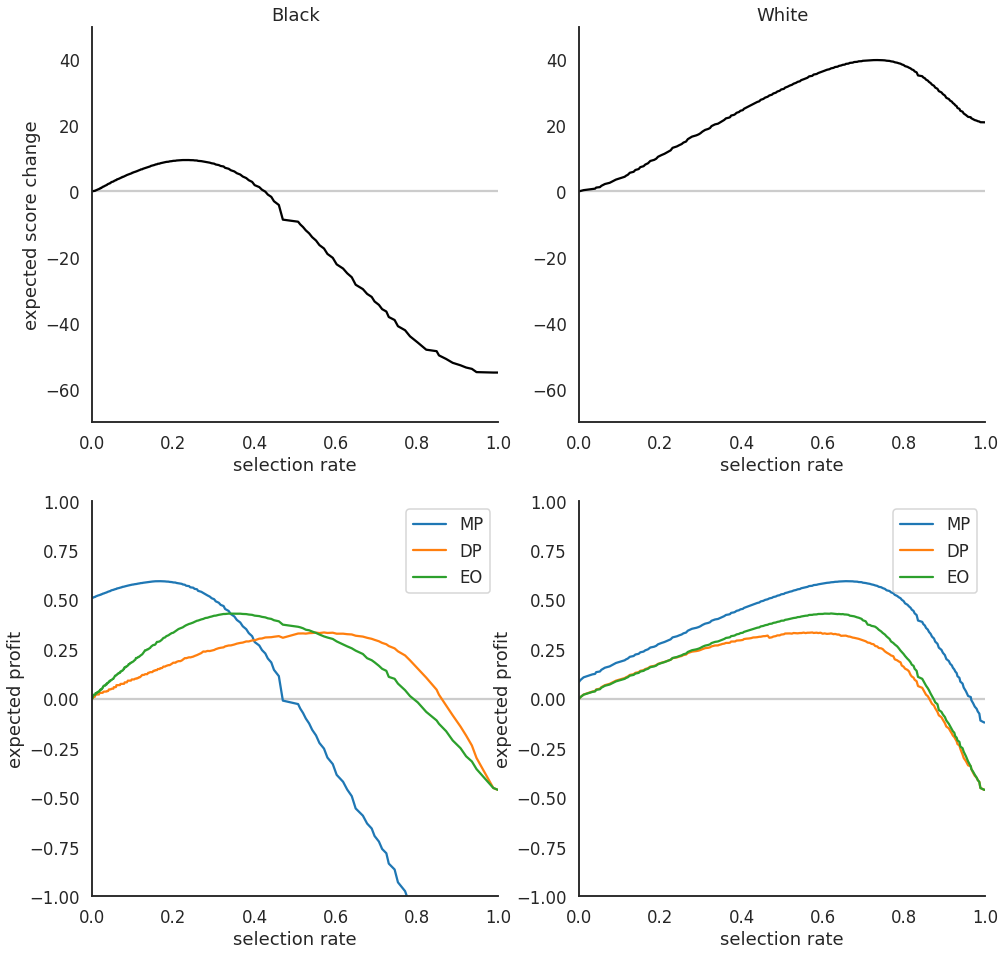

In [17]:
fig, ax = plt.subplots(2,2,figsize=(16,16)); 

for i in range(2):
    for j in range(2):
        ax[i,j].spines['right'].set_visible(False)
        ax[i,j].spines['top'].set_visible(False)
        ax[i,j].axhline(0,LineStyle='-', color='grey',alpha=0.4)
        
ax[0,0].plot(rate_index_A,outcome_curveA,color='black')
ax[0,0].set_xlabel('selection rate');
ax[0,0].set_ylabel('expected score change')
ax[0,0].set_title('Black'); 
ax[0,0].set_ylim([-70,50])
ax[0,0].set_xlim([0,1])

ax[0,1].plot(rate_index_B,outcome_curveB,color='black')
ax[0,1].set_xlabel('selection rate')
ax[0,1].set_title('White') 
ax[0,1].set_ylim([-70,50])
ax[0,1].set_xlim([0,1])

ax[1,0].plot(rate_index_A, utility_curves_MP[0], label='MP'); 
ax[1,0].plot(rate_index_A, utility_curves_DP[0], label='DP'); 
ax[1,0].plot(rate_index_A, utility_curves_EO[0], label='EO'); 
ax[1,0].set_xlabel('selection rate')
ax[1,0].set_ylabel('expected profit')
ax[1,0].set_ylim([-1,1])
ax[1,0].legend()
ax[1,0].set_xlim([0,1])

ax[1,1].plot(rate_index_B, utility_curves_MP[1], label='MP'); 
ax[1,1].plot(rate_index_B, utility_curves_DP[1], label='DP'); 
ax[1,1].plot(rate_index_B, utility_curves_EO[1], label='EO'); 
ax[1,1].set_xlabel('selection rate')
ax[1,1].set_ylabel('expected profit')
ax[1,1].set_ylim([-1,1])
ax[1,1].legend()
ax[1,1].set_xlim([0,1])
plt.suptitle("")
